In [1]:
import os
import torch
import sys
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

sys.path.append(".")

from models.DoubleUnet import UNet  


CHECKPOINT_PATH = "checkpoints/color_polygon_unet.pth"
INPUT_MASKS_DIR = "dataset/training/inputs"
SAVE_DIR = "predictions"
IMAGE_SIZE = 128

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def color_to_rgb(color_name):
    COLORS = {
        "red": (255, 0, 0),
        "green": (0, 255, 0),
        "blue": (0, 0, 255),
        "yellow": (255, 255, 0),
        "cyan": (0, 255, 255),
        "magenta": (255, 0, 255),
        "orange": (255, 165, 0),
        "purple": (128, 0, 128)
    }
    if color_name not in COLORS:
        raise ValueError(f"Color '{color_name}' not recognized.")
    return COLORS[color_name]


transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
])


model = UNet(in_channels=4, out_channels=3).to(DEVICE)
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE))
model.eval()


UNet(
  (enc1): DoubleConv(
    (net): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (net): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  

In [2]:
def predict(shape_name: str, color_name: str):
    mask_path = os.path.join(INPUT_MASKS_DIR, f"{shape_name}.png")
    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"No mask found for shape: {shape_name}")
    
    mask_tensor = transform(Image.open(mask_path).convert("L"))  # (1, H, W)

    rgb = color_to_rgb(color_name)
    color_tensor = torch.tensor(rgb, dtype=torch.float32).view(3, 1, 1).expand(-1, IMAGE_SIZE, IMAGE_SIZE) / 255.0

    input_tensor = torch.cat([mask_tensor, color_tensor], dim=0).unsqueeze(0).to(DEVICE)  # (1, 4, H, W)

    with torch.no_grad():
        output = model(input_tensor)[0].cpu()  # (3, H, W)

    output_image = T.ToPILImage()(output.clamp(0, 1))
    
    # Save output
    os.makedirs(SAVE_DIR, exist_ok=True)
    save_path = os.path.join(SAVE_DIR, f"{shape_name}_{color_name}_pred.png")
    output_image.save(save_path)
    
    return mask_tensor.squeeze(), output_image, save_path

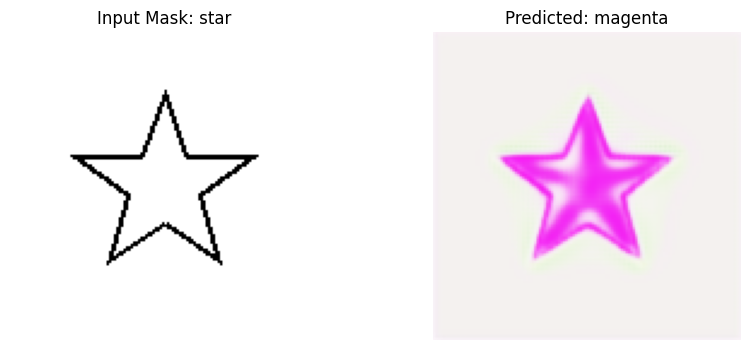

✅ Prediction saved at: predictions/star_magenta_pred.png


In [3]:
# Change shape and color here
shape = "star"
color = "magenta"

mask, output_image, path = predict(shape, color)

# Show input mask and predicted image
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title(f"Input Mask: {shape}")
plt.imshow(mask.numpy(), cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Predicted: {color}")
plt.imshow(output_image)
plt.axis("off")

plt.show()

print(f"✅ Prediction saved at: {path}")
